In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import ghalton
import numpy as np
import scipy.ndimage
import cPickle as pickle
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')
import theano
import theano.tensor as T
rng = np.random.RandomState(42)
theano.config.floatX = 'float32'

In [3]:
from utils import clean,to_radian,hann,res_to_rad
from get_data import get_data
from rotation_2d import rot_cost_func
from visualize import plot_cost_func
from cost_functions import cf_ssd
from mask import sphere_mask
from rotation_3d import volrotate,rot_cost_func_3d,rotation_matrix_zyx,tricubic_interp,tricubic_interp_A

In [ ]:
def plot_volume(volume,arg =''):
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(3)
    fig.set_figwidth(10)
    [ax[i].imshow(volume.max(axis=i), interpolation = 'None',cmap='gray') for i in xrange(3)]
    plt.suptitle(arg, fontsize=20)
    plt.show()
    plt.close(fig)

In [ ]:
# load in data
dict_10mm = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/dict_10mm.p','rb'))
dict_8mm = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/dict_8mm.p','rb'))
dict_6_4mm = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/dict_6_4mm.p','rb'))

In [ ]:
testVol1 = dict_8mm['body']['H15mm']['axis0']['0.0']
testVol1_masked = sphere_mask(testVol1,16)
testVol2 = dict_8mm['body']['H15mm']['axis0']['5.0']
testVol2_masked = sphere_mask(testVol2,16)

In [ ]:
def transform(volume, R, t):
    shape = volume.shape
    # find center of the volume
    ox = shape[1]/2.-0.5
    oy = shape[0]/2.-0.5
    oz = shape[2]/2.-0.5
    
    R_matrix = rotation_matrix_zyx(R[0],R[1],R[2])
    tmpx = np.linspace(0, shape[0]-1, shape[0]).astype(int)
    tmpy = np.linspace(0, shape[1]-1, shape[1]).astype(int)
    tmpz = np.linspace(0, shape[2]-1, shape[2]).astype(int)
    xx, yy, zz = np.meshgrid(tmpx, tmpx, tmpx)
    x, y, z = xx - ox, yy - oy, zz - oz
    dest_x, dest_y, dest_z = ((R_matrix[0][0]*x + R_matrix[0][1]*y + R_matrix[0][2]*z) + ox + t[0], 
                              (R_matrix[1][0]*x + R_matrix[1][1]*y + R_matrix[1][2]*z) + oy + t[1], 
                              (R_matrix[2][0]*x + R_matrix[2][1]*y + R_matrix[2][2]*z) + oz + t[2])
    n = shape[0]
    dest = np.empty([n,n,n])
    for i in xrange(shape[0]):
        for j in xrange(shape[1]):
            for k in xrange(shape[2]):
                dest[i,j,k] = tricubic_interp(volume,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k])
    return dest

In [ ]:
# helper function to calculate partial derivatives
def dx_dR(x,y,z,R):
    a, b, c = R
    dx_da = (-np.sin(a)*np.cos(b)*x - np.cos(a)*np.cos(c)*y - np.sin(a)*np.sin(b)*np.sin(c)*y + 
             np.cos(a)*np.sin(c)*z - np.sin(a)*np.sin(b)*np.cos(c)*z)
    dx_db = -np.cos(a)*np.sin(b)*x + np.cos(b)*np.cos(a)*np.sin(c)*y + np.cos(b)*np.cos(a)*np.cos(c)*z
    dx_dc = (np.sin(a)*np.sin(c)*y + np.sin(b)*np.cos(a)*np.cos(c)*y + 
             np.sin(a)*np.cos(c)*z - np.sin(b)*np.cos(a)*np.sin(c)*z)
    return np.array([dx_da, dx_db, dx_dc])

def dy_dR(x,y,z,R):
    a, b, c = R
    dy_da = (np.cos(a)*np.cos(b)*x - np.sin(a)*np.cos(c)*y + np.cos(a)*np.sin(b)*np.sin(c)*y + 
             np.sin(a)*np.sin(c)*z + np.cos(a)*np.sin(b)*np.cos(c)*z)
    dy_db = -np.sin(a)*np.sin(b)*x + np.cos(b)*np.sin(a)*np.sin(c)*y + np.cos(b)*np.sin(a)*np.cos(c)*z
    dy_dc = (-np.cos(a)*np.sin(c)*y + np.sin(b)*np.sin(a)*np.cos(c)*y - 
             np.cos(a)*np.cos(c)*z - np.sin(b)*np.sin(a)*np.sin(c)*z)
    return np.array([dy_da, dy_db, dy_dc])

def dz_dR(x,y,z,R):
    a, b, c = R
    dz_db = -np.cos(b)*x - np.sin(b)*np.sin(c)*y - np.sin(b)*np.cos(c)*z
    dz_dc = np.cos(b)*np.cos(c)*y - np.cos(b)*np.sin(c)*z
    return np.array([0, dz_db, dz_dc])

In [ ]:
def tricubic_gradient(vol1, vol2, x, y, z, R_deg, t):
    '''
    x, y, z are grid points
    R is an array for rotation angles
    t is an array for translations
    '''
    # Rotation matrix based on the three angles
    shape = vol1.shape
    # find center of the volume
    ox = shape[1]/2.-0.5
    oy = shape[0]/2.-0.5
    oz = shape[2]/2.-0.5
    R_matrix = rotation_matrix_zyx(R_deg[0],R_deg[1],R_deg[2])
    R = to_radian(R_deg)
    # Rotate the coordinates
    y_, x_, z_ = np.dot(R_matrix,np.array([y-oy,x-ox,z-oz]))
    x_ = x_ + ox + t[0]
    y_ = y_ + oy + t[1]
    z_ = z_ + oz + t[2]
    
    
    # Interpolate the volume at rotated points, and save the coefficients
    A, interp = tricubic_interp_A(vol2, y_, x_, z_)
    # Calculate SSD
    err = (interp - vol1[x,y,z])**2
    # Calculate the constant part of the gradient
    const = 2*(interp - vol1[x,y,z])
    idx = 0
    # Calculate the second part of the gradient
    gd_R = np.zeros(3)
    gd_t = np.ones(3)
    dx = dx_dR(x,y,z,R)
    dy = dy_dR(x,y,z,R)
    dz = dz_dR(x,y,z,R)
    
    x1 = np.floor(x_).astype(int)
    y1 = np.floor(y_).astype(int)
    z1 = np.floor(z_).astype(int)
    
    x_ -= x1
    y_ -= y1
    z_ -= z1
    
    for k in xrange(4):
        for j in xrange(4):
            for i in xrange(4):
                part1 = i*x_**(i-1)*y_**j*z_**k*dx
                part2 = j*y_**(j-1)*x_**i*z_**k*dy
                part3 = k*z_**(k-1)*x_**i*y_**j*dz
                # Need to handle gradient with i, j, k=0 to avoid nan
                if(i==0):
                    part1 = y_**j*z_**k*dx
                if(j==0):
                    part2 = x_**i*z_**k*dy
                if(k==0):
                    part3 = x_**i*y_**j*dz
                tmp = part1 + part2 + part3
                gd_R += A[idx]*tmp               
                idx += 1
    gd_R = gd_R * const
    gd_t = gd_t * const
    return err, gd_R, gd_t

In [ ]:
def gradient(vol1, vol2, R, t):
    shape = vol1.shape
    grad_R = 0.0
    grad_t = 0.0
    error = 0.0
    for x in xrange(shape[0]):
        for y in xrange(shape[1]):
            for z in xrange(shape[2]):
                err, gd_R, gd_t = tricubic_gradient(vol1, vol2, x,y,z, R,t)
                grad_R += gd_R
                grad_t += gd_t
                error += err
    return error, grad_R, grad_t

In [ ]:
R = np.zeros([3])
t = np.zeros([3])

newVol2 = transform(testVol2,R,t)
print cf_ssd(newVol2,testVol1)

In [ ]:
t0 = time.time()
error, grad_R, grad_t = gradient(testVol1,testVol2,R,t)
print error, grad_R, grad_t
print 'Time:' ,time.time()-t0

In [ ]:
R = np.array([0.0,5.0,0.0])
t = np.zeros([3])

t0 = time.time()
error, grad_R, grad_t = gradient(testVol1,testVol2,R,t)
print error, grad_R, grad_t
print 'Time:' ,time.time()-t0

In [ ]:
def gradient_descent(vol1, vol2, R, t, learning_rate, tol=1e-2):
    errors = []
    count = 0
    while True:
        count += 1
        R_old = R.copy()
        t_old = t.copy()
        error,rgd,rgt = gradient(vol1,vol2,R,t)
        errors.append(error)
        print R,t
        R -= learning_rate * rgd
        t -= learning_rate * rgt
        if((abs(np.max(R_old-R)) < tol) & (abs(np.max(t_old-t)) < tol)):
            break
    print 'Minimized error: ', error
    print 'Rotation matrix R:\n', R
    print 'Translation vector t:\n', t*8.0
    return errors, R, t

In [ ]:
R = np.zeros([3])
t = np.zeros([3])
errors, R, t = gradient_descent(testVol1,testVol2,R,t,-0.1)

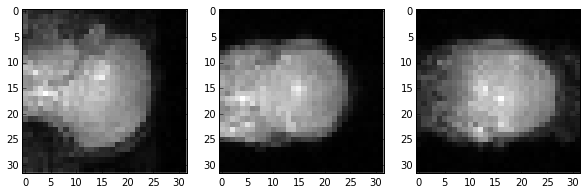

In [108]:
res = transform(testVol2,R,t)
plot_volume(res)

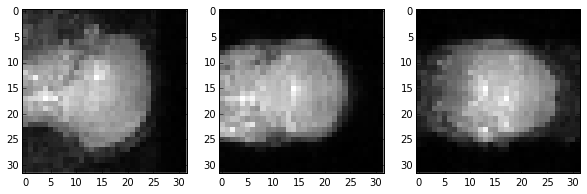

In [27]:
plot_volume(testVol1)